In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

THRESHOLD = 90

In [2]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [3]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
n_classes = len(np.unique(data['Lipid Class']))
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time (min),Peak Area of Lipid Species,Peak Area of Internal Standard,Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,4.165659e+07,0.001167


In [4]:
data.shape

(43434, 17)

In [5]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Individual Lipid Species', values=data.columns[16])
tot_lipids = data_pivot.shape[1] - 6
data_stats = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(0)
# data_stats.drop(columns=['Individual Lipid Species'])
data_stats.head()
lipids_ok = list(data_stats.columns[6:])

In [6]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

In [7]:
data_np = data_stats.values[:,6:] + 1e-10
data_np = np.log(data_np.astype('float64'))
print(data_np.shape)

(72, 372)


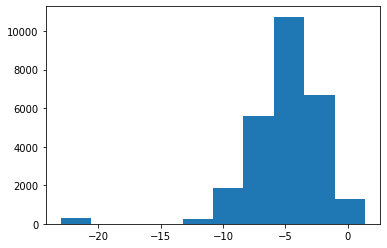

In [8]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

In [9]:
pca = PCA()
data_norm = StandardScaler().fit_transform(data_np)
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(72, 72)


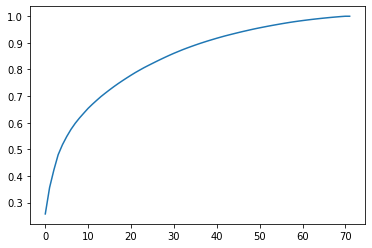

In [10]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [11]:
data_stats.shape

(72, 378)

In [12]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(72, 3)


In [35]:
p_values

array([[0.00000000e+00, 1.46586851e-04, 2.87280383e-01],
       [1.00000000e+00, 1.04494033e-01, 1.24421797e-01],
       [2.00000000e+00, 9.61042936e-01, 2.50787994e-01],
       [3.00000000e+00, 6.48766924e-01, 2.85179141e-01],
       [4.00000000e+00, 3.77486230e-01, 3.23223248e-01],
       [5.00000000e+00, 6.79882821e-01, 7.15397836e-01],
       [6.00000000e+00, 2.52311970e-01, 4.59044800e-01],
       [7.00000000e+00, 8.01348284e-01, 3.86608646e-01],
       [8.00000000e+00, 5.42462048e-01, 2.30188579e-01],
       [9.00000000e+00, 2.39716255e-02, 6.61995117e-01],
       [1.00000000e+01, 2.44404558e-01, 1.08239666e-01],
       [1.10000000e+01, 3.82784729e-01, 2.18374845e-01],
       [1.20000000e+01, 6.82094931e-01, 8.49295639e-01],
       [1.30000000e+01, 8.63788993e-01, 5.71486044e-02],
       [1.40000000e+01, 4.11701634e-01, 6.64955274e-03],
       [1.50000000e+01, 6.35592717e-01, 9.45249894e-01],
       [1.60000000e+01, 8.60757825e-02, 7.05068260e-01],
       [1.70000000e+01, 4.50202

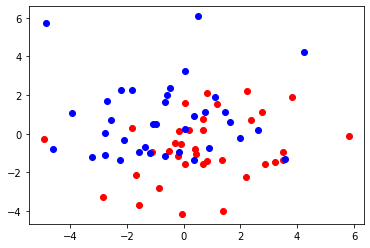

In [13]:
plt.scatter(data_pca[data_stats['Treatment']==0, 14], data_pca[data_stats['Treatment']==0, 21],c="red")
plt.scatter(data_pca[data_stats['Treatment']==1, 14], data_pca[data_stats['Treatment']==1, 21],c="blue")
plt.show()

### EXAMPLE WITH PARTIAL LEAST SQUARE - DA

In [66]:
from sklearn.cross_decomposition import PLSRegression
pls2_treatment = PLSRegression(n_components=72, scale = False)
pls2_date = PLSRegression(n_components=72, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_norm, data_stats['Treatment'].values)
data_pls2_date = pls2_date.fit_transform(data_norm, data_stats['Sample Submission Date'].values)


/home/ivan/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 55
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/ivan/.local/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 55
  warnings.warn(f"Y residual is constant at iteration {k}")


In [67]:
print(data_pls2_treatment[0].shape)
print(data_pls2_date[0].shape)

(72, 72)
(72, 72)


In [54]:
data_pls2_treatment[0]

array([[ 0.8627207 ,  8.15252639, -1.43205113, ...,  0.        ,
         0.        ,  0.        ],
       [-1.58591843,  4.84439443, -7.9130282 , ...,  0.        ,
         0.        ,  0.        ],
       [12.45724662,  7.04821415,  4.31145251, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.71639784, -1.06590207, 13.01775933, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93392201,  0.82002363, -1.68685053, ...,  0.        ,
         0.        ,  0.        ],
       [-5.50621558, -7.20302168,  3.58957083, ...,  0.        ,
         0.        ,  0.        ]])

In [68]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_date[0][data_stats['Sample Submission Date']==0, d], data_pls2_date[0][data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pls2_treatment[0][data_stats['Treatment']==0, d], data_pls2_treatment[0][data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(72, 3)


In [56]:
p_values_pls2

array([[0.00000000e+00, 4.72146976e-06, 1.21213815e-04],
       [1.00000000e+00, 8.62094739e-05, 8.88203009e-06],
       [2.00000000e+00, 3.99239092e-05, 1.48856851e-06],
       [3.00000000e+00, 4.02092871e-03, 6.11802244e-03],
       [4.00000000e+00, 1.52270794e-02, 1.77364054e-02],
       [5.00000000e+00, 4.81419247e-02, 7.60571292e-02],
       [6.00000000e+00, 1.14378163e-01, 2.15167545e-01],
       [7.00000000e+00, 3.05779580e-01, 3.05676420e-01],
       [8.00000000e+00, 3.59361404e-01, 4.58934824e-01],
       [9.00000000e+00, 4.05941086e-01, 5.59638368e-01],
       [1.00000000e+01, 6.68314765e-01, 6.87456792e-01],
       [1.10000000e+01, 7.33173610e-01, 8.11841979e-01],
       [1.20000000e+01, 8.55878582e-01, 8.66239980e-01],
       [1.30000000e+01, 8.97674220e-01, 9.00621533e-01],
       [1.40000000e+01, 9.43882357e-01, 9.39310541e-01],
       [1.50000000e+01, 9.63931025e-01, 9.58302128e-01],
       [1.60000000e+01, 9.75744719e-01, 9.75599984e-01],
       [1.70000000e+01, 9.85269

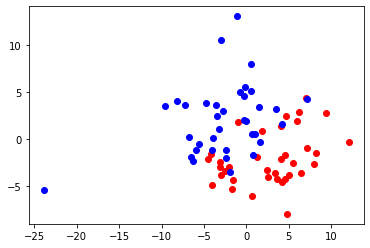

In [57]:
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==0, 1], data_pls2_treatment[0][data_stats['Treatment']==0, 2],c="red")
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==1, 1], data_pls2_treatment[0][data_stats['Treatment']==1, 2],c="blue")
plt.show()

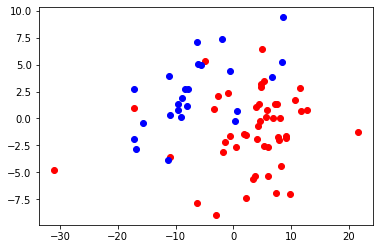

In [69]:
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==0, 0], data_pls2_date[0][data_stats['Sample Submission Date']==0, 1],c="red")
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==1, 0], data_pls2_date[0][data_stats['Sample Submission Date']==1, 1],c="blue")
plt.show()

In [70]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values_pls2[:,2]<0.05)} significant pc with respect to TREATMENT')
print(f'{np.sum((p_values_pls2[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,2]<0.05)[0]
significant_pc_pls2_date = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)
print(significant_pc_pls2_date)

6 significant pc with respect to date
5 significant pc with respect to TREATMENT
1 significant pc with respect to both
[0 1 2 3 4]
[0 1 2 3 4 5]


In [80]:
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
print(significant_components_pls2_treatment.shape)
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)
print(max_values_pls2_treatment.shape)

(5, 372)
(372,)


In [81]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T.flatten()), THRESHOLD)

In [82]:
idx_significant_lipids_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_lipids_pls2_treatment = len(idx_significant_lipids_pls2_treatment)
print(f'{n_significant_lipids_pls2_treatment} ({n_significant_lipids_pls2_treatment/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_treatment = [lipids_ok[i] for i in idx_significant_lipids_pls2_treatment]

192 (22.48% of original total) significant lipids found


In [83]:
significant_components_pls2_date = pls2_date.x_weights_.T[significant_pc_pls2_date,:]
print(significant_components_pls2_date.shape)
max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)
print(max_values_pls2_date.shape)

(6, 372)
(372,)


In [84]:
ths_pls2_date = np.percentile(np.abs(pls2_date.x_weights_.T.flatten()), THRESHOLD)

In [85]:
idx_significant_lipids_pls2_date = np.where(max_values_pls2_date>ths_pls2_date)[0]
n_significant_lipids_pls2_date = len(idx_significant_lipids_pls2_date)
print(f'{n_significant_lipids_pls2_date} ({n_significant_lipids_pls2_date/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_date = [lipids_ok[i] for i in idx_significant_lipids_pls2_date]

215 (25.18% of original total) significant lipids found


In [86]:
lipid_classes_pls2_treatment = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_treatment])
print(f'{len(lipid_classes_pls2_treatment)} ({len(lipid_classes_pls2_treatment)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_treatment)

16 (76.19% of original total) lipid classes found
['CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPI' 'LPS' 'MAG' 'PC' 'PE' 'PG'
 'PI' 'PS' 'SM' 'TAG']


In [87]:
lipid_classes_pls2_date = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_date])
print(f'{len(lipid_classes_pls2_date)} ({len(lipid_classes_pls2_date)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_date)

18 (85.71% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPG' 'LPI' 'LPS' 'MAG' 'PC'
 'PE' 'PG' 'PI' 'PS' 'SM' 'TAG']


In [94]:
unique_set_treatment = set(significant_lipids_pls2_treatment).difference(set(significant_lipids_pls2_date))
unique_list_treatment = list(unique_set_treatment)
unique_list_treatment

['LPI(20:3)-H',
 'PE(O-18:0_16:1)-H',
 'TAG(56:6_FA20:4)+NH4',
 'PE(18:1_22:6)-H',
 'DAG(16:1_20:4)+NH4',
 'TAG(52:4_FA18:2)+NH4',
 'DCER(18:0)+H',
 'TAG(56:7_FA20:3)+NH4',
 'PS(18:0_18:0)-H',
 'PE(16:0_20:4)-H',
 'PE(18:1_18:2)-H',
 'PG(18:0_20:3)-H',
 'PE(P-16:0_16:1)-H',
 'PC(18:2_20:4)+AcO',
 'TAG(58:10_FA20:4)+NH4',
 'TAG(54:4_FA20:4)+NH4',
 'PI(14:0_20:1)-H',
 'TAG(54:5_FA20:4)+NH4',
 'PE(P-18:1_18:2)-H',
 'TAG(56:6_FA22:6)+NH4',
 'PS(18:0_22:4)-H',
 'LPI(20:4)-H',
 'CER(18:1)+H',
 'PG(18:0_22:4)-H',
 'MAG(16:1)+NH4',
 'PE(16:0_20:3)-H',
 'LPC(22:5)+AcO',
 'TAG(52:4_FA20:4)+NH4',
 'PE(P-18:0_16:0)-H',
 'PS(18:0_18:1)-H',
 'PE(P-18:0_22:6)-H',
 'CER(24:0)+H',
 'PS(18:0_18:2)-H',
 'PI(18:1_18:2)-H',
 'LPI(20:1)-H',
 'PS(18:0_20:1)-H',
 'PI(18:1_20:3)-H',
 'PI(18:1_20:4)-H',
 'MAG(22:6)+NH4',
 'PI(18:1_16:1)-H',
 'PS(18:0_20:0)-H',
 'PE(P-18:1_22:5)-H',
 'PG(16:0_22:6)-H',
 'PI(18:2_22:6)-H',
 'PS(18:2_20:4)-H',
 'PE(O-18:0_16:0)-H',
 'PS(16:0_22:6)-H',
 'TAG(46:4_FA18:2)+NH4',
 'TA

In [95]:
with open('significant_lipids_pls2_treatment.txt', 'w') as f:
    for l in significant_lipids_pls2_treatment:
        f.write(l+'\n')

In [96]:
with open('significant_lipids_pls2_date.txt', 'w') as f:
    for l in significant_lipids_pls2_date:
        f.write(l+'\n')

In [97]:
with open('significant_lipids_pls2_unique_treatment.txt', 'w') as f:
    for l in unique_list_treatment:
        f.write(l+'\n')

### ENDING OF PARTIAL LEAST SQUARE - DA EXAMPLE

In [25]:
p_values

array([[0.00000000e+00, 1.46586851e-04, 2.87280383e-01],
       [1.00000000e+00, 1.04494033e-01, 1.24421797e-01],
       [2.00000000e+00, 9.61042936e-01, 2.50787994e-01],
       [3.00000000e+00, 6.48766924e-01, 2.85179141e-01],
       [4.00000000e+00, 3.77486230e-01, 3.23223248e-01],
       [5.00000000e+00, 6.79882821e-01, 7.15397836e-01],
       [6.00000000e+00, 2.52311970e-01, 4.59044800e-01],
       [7.00000000e+00, 8.01348284e-01, 3.86608646e-01],
       [8.00000000e+00, 5.42462048e-01, 2.30188579e-01],
       [9.00000000e+00, 2.39716255e-02, 6.61995117e-01],
       [1.00000000e+01, 2.44404558e-01, 1.08239666e-01],
       [1.10000000e+01, 3.82784729e-01, 2.18374845e-01],
       [1.20000000e+01, 6.82094931e-01, 8.49295639e-01],
       [1.30000000e+01, 8.63788993e-01, 5.71486044e-02],
       [1.40000000e+01, 4.11701634e-01, 6.64955274e-03],
       [1.50000000e+01, 6.35592717e-01, 9.45249894e-01],
       [1.60000000e+01, 8.60757825e-02, 7.05068260e-01],
       [1.70000000e+01, 4.50202

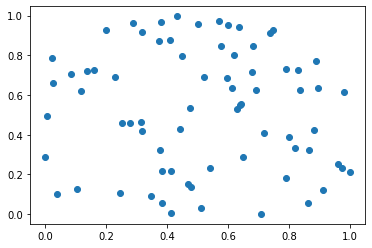

In [26]:
plt.figure()
plt.plot(p_values[:,1], p_values[:,2],'o')
plt.show()

In [27]:
print(f'{np.sum(p_values[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values[:,2]<0.05)} significant pc with respect to date')
print(f'{np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc = np.where(p_values[:,2]<0.05)[0]

5 significant pc with respect to date
3 significant pc with respect to date
0 significant pc with respect to both


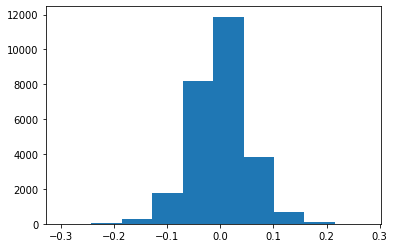

0.08449578223812229


In [28]:
plt.figure()
plt.hist(pca.components_.flatten())
plt.show()
ths = np.percentile(np.abs(pca.components_.flatten()), THRESHOLD)
print(ths)

In [29]:
significant_components = pca.components_[significant_pc,:]
print(significant_components.shape)
max_values = np.max(np.abs(significant_components), axis=0)
print(max_values.shape)

(3, 372)
(372,)


In [57]:
idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids = [lipids_ok[i] for i in idx_significant_lipids]

121 (14.17% of original total) significant lipids found


In [58]:
lipid_classes = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids])
print(f'{len(lipid_classes)} ({len(lipid_classes)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes)

16 (76.19% of original total) lipid classes found
['CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPI' 'LPS' 'MAG' 'PC' 'PE' 'PG'
 'PI' 'PS' 'SM' 'TAG']


In [59]:
date_pc = np.where(p_values[:,1]<0.05)[0]
significant_components = pca.components_[date_pc,:]
max_values = np.max(np.abs(significant_components), axis=0)

idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) date dependent lipids found')
date_lipids = [lipids_ok[i] for i in idx_significant_lipids]

121 (14.17% of original total) date dependent lipids found


In [60]:
with open('significant_lipids.txt', 'w') as f:
    for l in significant_lipids:
        f.write(l+'\n')

with open('date_lipids.txt', 'w') as f:
    for l in date_lipids:
        f.write(l+'\n')

with open('significant_lipid_classes.txt', 'w') as f:
    for l in lipid_classes:
        f.write(l+'\n')